In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from collections import deque
from functools import lru_cache
from PIL import Image

# Studies in Digital Signal Processing, Project 1

## Section 1

### Section 1-A

The goal of this exercise is to study signal decimation and interpolation.
We will write a Python function that takes an input signal x[n] and returns a signal y[n], which is the decimation of the input signal x[n] by a factor of 2.
Next, we will use our function to find the decimated signal for the input:

$$ x = \left[1, 2, 1, 0, 1, 2, 1, 0, 1, 2, 1, 0, 1, 2, 1, 0, 1, 2, 1, 0 \right]$$

In [2]:
def decimate_by_2(signal: np.ndarray) -> np.ndarray:
    length = len(signal)
    decimated = np.zeros(length // 2 + int(length % 2 != 0))
    idx = 0
    for i in range(0, len(signal), 2):
        decimated[idx] = signal[i]
        idx += 1
    return decimated


s = np.array([1, 2, 1, 0, 1, 2, 1, 0, 1, 2, 1, 0, 1, 2, 1, 0, 1, 2, 1, 0])
print('Signal =', s)
s = decimate_by_2(signal=s)
print('Decimated =', *s, sep=', ')

Signal = [1 2 1 0 1 2 1 0 1 2 1 0 1 2 1 0 1 2 1 0]
Decimated =, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0


### Section 1-B

Let’s write a Python function that takes an input signal y[n] and returns a signal z[n], which is the interpolation of the input signal y[n] by a factor of 2. Our function should increase the number of samples and assign a new value to the created samples. We can choose whether the interpolated samples will have the average value of the surrounding samples or the value of the previous sample. Next, let’s use our function to find the interpolated signal for the y[n] signal from the previous section.


In [3]:
def interpolate_by_2(signal: np.ndarray) -> np.ndarray:
    length = len(signal)
    interpolated = np.zeros(length * 2)
    idx = 0
    for i in range(length * 2 - 1):
        if i % 2 == 0:
            interpolated[i] = float(signal[idx])
            idx += 1
        else:
            interpolated[i] = (signal[idx] + signal[idx - 1]) / 2
    interpolated[-1] = signal[-1] / 2
    return interpolated


s = interpolate_by_2(signal=s)
print('Interpolated =', *s, sep=', ')
print('')

Interpolated =, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5



### Section 1-C

An image is a two-dimensional discrete signal.
We represent this image as I(x, y), which is a two-dimensional matrix with dimensions (w x h), where w is the image width and h is the image height.

For images, we perform decimation and interpolation separately for all rows and then for all columns (or vice-versa), considering that each row or column is a one-dimensional signal.

Let’s apply our decimation algorithm successively until we obtain an image with dimensions (w/16 x h/16), that is, applying the algorithm 4 times in a row, and then we will display the resulting image.

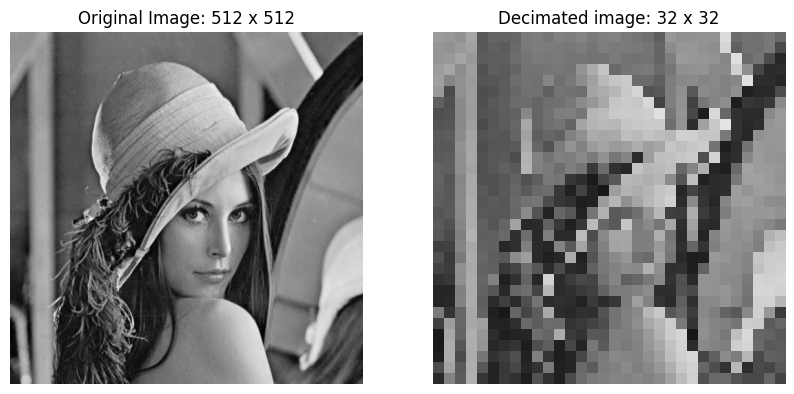

In [4]:
def iterate_decimation(arr: np.ndarray) -> np.ndarray:
    h, w = arr.shape
    for _ in range(4):
        new_arr = np.zeros((h, w // 2))
        for i in range(len(arr)):
            new_arr[i] = decimate_by_2(arr[i])
        arr = new_arr
        h, w = arr.shape
    return arr


im = Image.open('lena.bmp')
arr = np.array(im)
h, w = arr.shape
ax = plt.subplots(1,2, figsize=(10, 5))[1]
ax[0].imshow(im, cmap='gray')
ax[0].axis('off')
ax[0].set_title(f'Original Image: {h} x {w}')
arr = iterate_decimation(arr=arr.T)
arr = iterate_decimation(arr=arr.T)
h, w = arr.shape
im = Image.fromarray(arr)
ax[1].imshow(im, cmap='gray')
ax[1].axis('off')
ax[1].set_title(f'Decimated image: {h} x {w}')
plt.show()


### Section 1-D

Using the decimated image (with size w/16 x h/16) from the previous question (1c) as input, let’s apply our interpolation algorithm successively until we obtain an image with dimensions (w x h). In other words, we will apply the algorithm 4 times in a row and then display the resulting image.

Finally, we’ll compare the original image with the one that was decimated and interpolated.

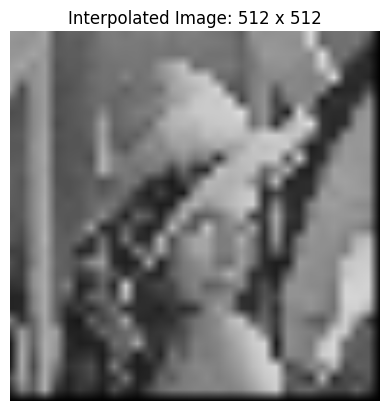

In [5]:
def iterate_interpolation(arr: np.ndarray) -> np.ndarray:
    h, w = arr.shape
    for _ in range(4):
        new_arr = np.zeros((h, w * 2))
        for i in range(len(arr)):
            new_arr[i] = interpolate_by_2(arr[i])
        arr = new_arr
        h, w = arr.shape
    return arr


arr = iterate_interpolation(arr=arr.T)
arr = iterate_interpolation(arr=arr.T)
h, w = arr.shape
im = Image.fromarray(arr)
ax = plt.subplots(1,1)[1]
ax.imshow(im)
ax.set_title(f'Interpolated Image: {h} x {w}')
ax.axis('off')
plt.show()

## Section 2

Let’s now consider the following Linear Discrete-Time Invariant (LTI) system:
$$ y\left[n+2\right] + \frac{1}{6}y\left[n\right] = x\left[n+2\right] + 2x\left[n+1\right]+x\left[n\right] $$
$$ x\left[n\right] = \left(\frac{1}{4}\right)^n u\left[n\right] $$
$$ y\left[-1\right] = y\left[-2\right] = 0 $$

### Section 2-A

Let’s determine the impulse response h[n] of the given LTI system analytically.

Let’s rewrite the given system as:

$(E^2 + \frac{1}{6})y[n] = (E^2 + 2E + 1)x[n]$

From this, we derive the characteristic equation:

$\gamma^2 + \frac{1}{6} = 0$

The discriminant is:

$\Delta = 0^2 - 4(1)(\frac{1}{6}) = -\frac{2}{3}$

The characteristic roots are:

$\gamma = \frac{\pm j\sqrt{\frac{2}{3}}}{2} = \pm j\sqrt{\frac{2}{3}} \cdot \sqrt{\frac{1}{4}} = \pm j\sqrt{\frac{1}{6}}$

The magnitude of the characteristic roots is:

$|\gamma| = \sqrt{\frac{1}{6}}$

Thus, the natural solution of the system is given by:

$y_c[n] = C \Big(\sqrt{\frac{1}{6}}\Big)^n \cos(\frac{\pi}{2}n + \theta)$

Now, to find the impulse response, we write:

$h[n] = \frac{b_n}{a_n}\delta[n] + y_c[n]$

$h[n] = 6\delta[n] + C \Big(\sqrt{\frac{1}{6}}\Big)^n \cos(\frac{\pi}{2}n + \theta)$

To find the constants of the system, we can set up a system of equations by substituting y[−1] and y[−2]:

$h[0] = -\frac{1}{6}h[-2] + \delta[0] + 2\delta[-1] + \delta[-2] = 1$

$h[1] = -\frac{1}{6}h[-1] + \delta[1] + 2\delta[0] + \delta[-1] = 2$

Thus, we can determine the constants $C$ and $\theta$ by substituting $h[-1]$ and $h[-2]$:

$6 + C\cos(\theta) = 1$

$C \sqrt{\frac{1}{6}} \cos(\frac{\pi}{2} + \theta) = 2$

Solving the system, we obtain $C \approx -7$ and $\theta \approx 0.7753$ rad. Finally, the impulse response will be described by:

$h[n] = 6\delta[n] - 7\Big(\sqrt{\frac{1}{6}}\Big)^n \cos(\frac{\pi}{2}n + 0.7753)$, $n \geq 0$





### Section 2-B
In this section, we will write a code to obtain the impulse response h[n] iteratively, and then compare the iteratively obtained response with the analytical response for the first 100 samples by plotting the graph of the two responses.

Additionally, we will also compute the mean square error between the two signals, h[n] analytical and g[n] iterative, using the equation:

$$ MSE = \frac{1}{N} \sum_{i=0}^{N-1} \left( h\left[i\right] - g\left[i\right] \right)^2 $$

where N is the number of samples considered (in this case, 100 samples).

MSE = 3.261474194116763e-09


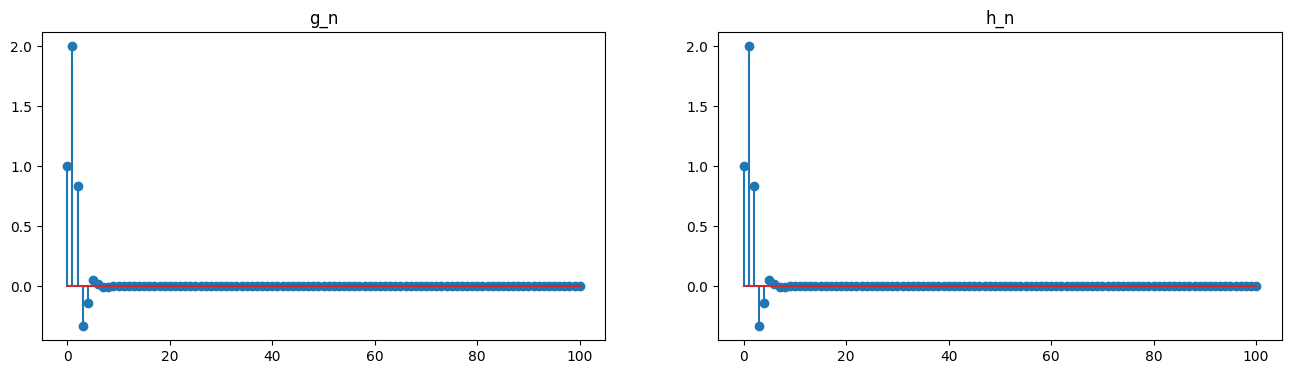

In [6]:
def delta(n: int) -> int: # Dirac Delta
    return int(n == 0)


def g(n: int) -> float: # Corresponds to the analytically calculated impulse response
    return 6 * delta(n) - 7 * ((1/6)**0.5)**n * np.cos(np.pi/2 * n + 0.7753)


@lru_cache(maxsize=102)
def h(n: int) -> float: # Corresponds to the iteratively calculated impulse response
    if  n < 0:
        return 0
    return (-1/6)*h(n-2) + delta(n) + 2*delta(n-1) + delta(n-2)


def calculate_mse(h: list, g: list) -> float: # Calculate the mean squared error between h[n] and g[n]
    result = 0
    for i in range(len(h)):
        result += (h[i] - g[i]) ** 2
    result /= len(h)
    return result


n = [i for i in range(101)]
h_n = [h(i) for i in n]
g_n = [g(i) for i in n]
print('MSE =', calculate_mse(h_n, g_n))
ax = plt.subplots(1, 2, figsize=(16, 4))[1]
ax[0].stem(n, g_n)
ax[0].set_title('g_n')
ax[1].stem(n, h_n)
ax[1].set_title('h_n')
plt.show()

### Section 2-C

Let's now determine the response of the system to the given initial conditions analytically.

We can determine the transfer function as:

$H(z) = \frac{z^2 + 2z + 1}{z^2 + \frac{1}{6}}$

The forced response will be:

$y_\phi[n] = H\Big(\frac{1}{4}\Big) \Big(\frac{1}{4}\Big)^n u[n] = 6.81 \Big(\frac{1}{4}\Big)^n u[n]$

And its natural response, as previously determined, is given by:

$y_c[n] = C \Big( \sqrt{\frac{1}{6}} \Big)^n \cos(\frac{\pi}{2}n + \theta)$

To determine the complete answer, considering that $y[n] = 0\ \forall \ n < 0$, we can substitute $n = -2$ and $n = -1$:

$y[n+2] = -\frac{1}{6}y[n] + x[n+2] + 2x[n+1] + x[n]$

$y[0] = -\frac{1}{6}y[-2] + x[0] + 2x[-1] + x[-2] = 1$

$y[1] = -\frac{1}{6}y[-1] + x[1] + 2x[0] + x[-1] = 2.25$

Therefore, we obtain the system:

$C \cos(\theta) = -5.81$

$C \Big(\sqrt{\frac{1}{6}} \cos(\frac{\pi}{2} + \theta) + 1.7025 = 2.25 \Big)$

And, when solving the system, we will obtain $C \approx -5.96$ and $\theta \approx 0.226$ rad. We conclude, therefore, that the response of the system is given by:

$y_\phi + y_c = 6.81 \Big(\frac{1}{4}\Big)^n - 5.96 \Big(\sqrt{\frac{1}{6}}\Big)^n \cos(\frac{\pi}{2} n + 0.226)$, $n \geq 0$


### Section 2-D
In this section, we will write a program to obtain the response of the system by convolving the input with the impulse response h[n] truncated to the first 20 samples (i.e., considering only the first 20 samples of h[n]).

We will then compare the response obtained by convolution with the response obtained analytically by plotting the two responses (for the first 100 samples of the signal). Also calculate the mean square error between the two signals.

MSE = 1.211281840171045e-07


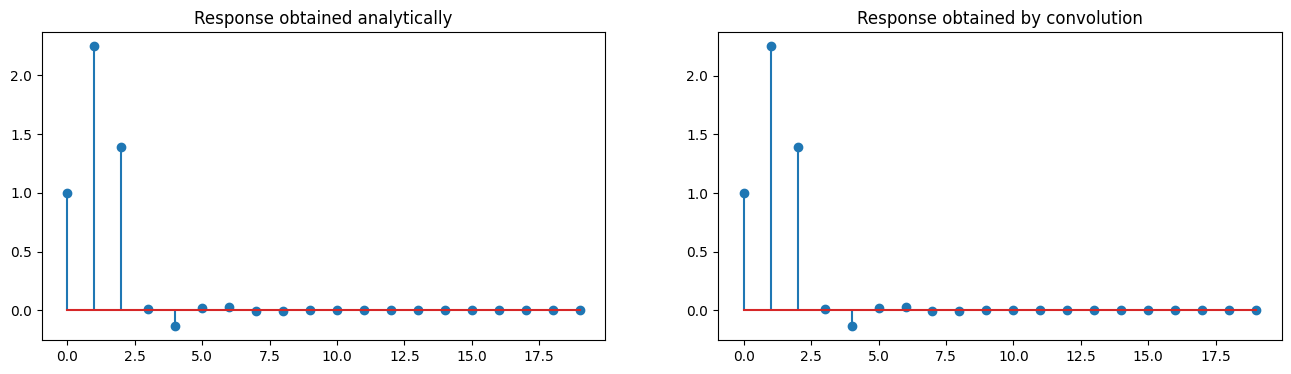

In [7]:
def x(n: int) -> float:
    return (1/4)**n * int(n >= 0)


def analytical(n: int) -> float: # System response obtained analytically
    return 6.81 * ((1/4)**n) - 5.96 * ((1/6)**0.5)**n * np.cos(np.pi/2 * n + 0.226)


def convolutional(x: list, h: list) -> list: # System response through convolution (first 100 samples only)
    y = [0 for _ in range(len(x))]
    h_deque = deque(h)
    while len(h_deque) < len(y):
        h_deque.appendleft(0)
    for i in range(len(y)):
        h_deque.rotate(1)
        y[i] += sum([h_deque[j] * x[j] for j in range(i, -1, -1)])
    return y


x_n = [x(i) for i in n]
y_n_analytical  = [analytical(i) for i in n]
h_n_reversed = h_n[::-1]
y_n_convolutional = convolutional(x_n, h_n_reversed)
print('MSE =', calculate_mse(y_n_analytical, y_n_convolutional))
ax = plt.subplots(1, 2, figsize=(16, 4))[1]
ax[0].stem(range(20), y_n_analytical[:20]) # Plot only the first 20 samples for analytical y[n]
ax[0].set_title('Response obtained analytically')
ax[1].stem(range(20), y_n_convolutional[:20]) # Plot only the first 20 samples for convolutional y[n]
ax[1].set_title('Response obtained by convolution')
plt.show()

### Section 2-E

Using the provided signal ('data_projeto1.mat') as input, we will determine the system response, and also plot the graph of the system input and output.

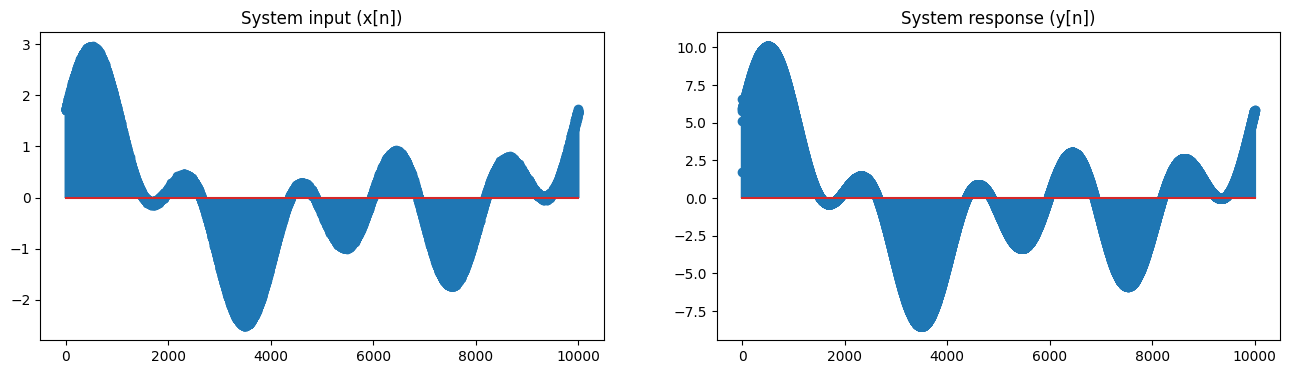

In [8]:
x_n = sp.io.loadmat('data_projeto1.mat')['sinal'].ravel()


def x(n: int) -> float: # System input
    if n < 0:
        return 0
    return x_n[n]


@lru_cache(maxsize=len(x_n))
def y(n: int) -> float: # Iteratively calculated system output
    if  n < 0:
        return 0
    return (-1/6)*y(n-2) + x(n) + 2*x(n-1) + x(n-2) 


n = list(range(len(x_n)))
y_n = [y(i) for i in range(len(x_n))]
ax = plt.subplots(1,2, figsize=(16,4))[1]
ax[0].stem(n, x_n)
ax[0].set_title('System input (x[n])')
ax[1].stem(n, y_n)
ax[1].set_title('System response (y[n])')
plt.show()

## Section 3
Consider the following discrete linear time-invariant system:
$$ y\left[n+2\right] -2~\cos \left( \frac{\pi}{8} \right) y\left[n+1\right] + y\left[n\right] = x\left[n\right] $$

### Section 3-A
We will first determine the impulse response h[n] analytically.

We can rewrite the system as:

$(E^2 - 2\cos(\frac{\pi}{8})E + 1)y[n] = (1)x[n]$

With the following characteristic equation:

$\gamma^{2} -2\cos(\frac{\pi}{8})\gamma + 1 = 0$

We will obtain the characteristic roots:

$\Delta = (-2\cos(\frac{\pi}{8}))^{2} - 4 (1) (1) = 4 (\cos(\frac{\pi}{8})^2 - 1) = -4\sin(\frac{\pi}{8})^2$

$\gamma = \frac{2\cos(\frac{\pi}{8}) \pm  j2\sin(\frac{\pi}{8})}{2} = \cos(\frac{\pi}{8}) \pm  j\sin(\frac{\pi}{8}) = e^{\pm j\frac{\pi}{8}}$

And we can obtain the impulse response:

$h[n] = \delta[n] + C \cos(\frac{\pi}{8}n + \theta)$

Considering $h[n] = 0 \ \forall \ n < 0$, we can replace $n = -1$ and $n = -2$ in the signal:

$h[n] = \delta[n] - h[n+2] + 2\cos(\frac{\pi}{8})h[n+1]$

$h[-2] = \delta[-2] - h[0] + 2\cos(\frac{\pi}{8})h[-1]$

$0 = 0 - h[0] + 0 \rightarrow h[0] = 0$

$h[-1] = \delta[-1] - h[1] + 2\cos(\frac{\pi}{8})h[0]$

$0 = 0 - h[1] + 0 \rightarrow h[1] = 0$

Having obtained the initial conditions $h[0] = 0$ and $h[1] = 0$, we can obtain $h[2]$ and $h[3]$ iteratively:

$h[0] = \delta[0] - h[2] + 2\cos(\frac{\pi}{8})h[1]$

$0 = 1 - h[2] + 0 \rightarrow h[2] = 1$

$h[1] = \delta[1] - h[3] + 2\cos(\frac{\pi}{8})h[2]$

$0 = 0 - h[3] + 2\cos(\frac{\pi}{8}) \rightarrow h[3] = 2\cos(\frac{\pi}{8})$

We can therefore set up the system of equations from the impulse equation, in order to find the constants $C$ and $\theta$:

$h[n] = \delta[n] + C \cos(\frac{\pi}{8}n + \theta)$

$h[2] = C \cos(\frac{\pi}{8}\cdot2 + theta) \rightarrow C\cos(\frac{\pi}{4} + theta) = 1$

$h[3] = C \cos(\frac{\pi}{8}\cdot3 + theta) \rightarrow C\cos(\frac{3\pi}{8} + theta) = 2\cos(\frac{\pi}{8})$

Solving the system, we conclude that $C \approx -2.613$ and $\theta \approx 1.178$ and, therefore, the impulse response will be given by:

$h[n] = \delta[n] - 2.613126 \cos(\frac{\pi}{8}n + 1.178097)$


### Section 3-B
In this section, we will write a program to obtain the impulse response h[n] iteratively, then compare the obtained response with the analytical response by plotting the graph of the two responses for the first 100 samples, and also compute the mean square error between the two signals.

MSE = 2.1023089102289274e-13


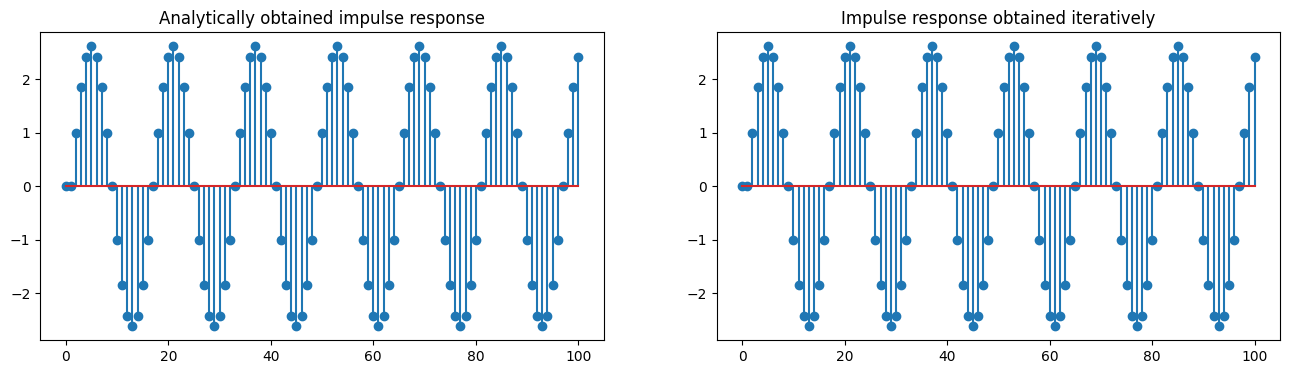

In [9]:
COS_CONSTANT = np.cos(np.pi/8)


def h_analytical(n: int) -> float: # h[n] determined analytically
    if n < 0:
        return 0
    return delta(n) - 2.613126 * np.cos(np.pi/8 * n + 1.178097)


@lru_cache(maxsize=102)
def h_iterative(n: int) -> float: # h[n] determined iteratively
    if n < 0:
        return 0
    return 2 * COS_CONSTANT * h_iterative(n-1) - h_iterative(n-2) + delta(n-2)


n = [i for i in range(101)]
h_n_analytical = [h_analytical(i) for i in n]
h_n_iterative = [h_iterative(i) for i in n]
print('MSE =', calculate_mse(h_n_analytical, h_n_iterative))
ax = plt.subplots(1, 2, figsize=(16, 4))[1]
ax[0].stem(n, h_n_analytical)
ax[0].set_title('Analytically obtained impulse response')
ax[1].stem(n, h_n_iterative)
ax[1].set_title('Impulse response obtained iteratively')
plt.show()